<a href="https://colab.research.google.com/github/JungWoo-Chae/GANs_TF2.x/blob/main/BEGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **BEGAN**

## **Imports**

In [1]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.datasets import mnist

import numpy as np
import matplotlib.pyplot as plt

## **Hyperparameters**

In [2]:
lr = 0.0002
epochs = 20
batch_size = 128

z_dim = 100 
nf =64
lambda_k = 0.001
gamma = 1.0
k= 0.0

## **Data Preprocessing**

In [3]:
(x_train, _), _ = mnist.load_data()
x_train = (x_train.astype(np.float32)-127.5) / 127.5
train_data = tf.data.Dataset.from_tensor_slices(x_train).shuffle(10000).batch(batch_size).prefetch(1)

11493376/11490434 [==============================] - 0s 0us/step


## **Model**

In [4]:
class Generator(Model):
    def __init__(self, nf):
        super(Generator, self).__init__()
        self.fc = tf.keras.Sequential([layers.Dense(7 * 7 * nf * 4),
                                        layers.BatchNormalization(),
                                       layers.LeakyReLU(),
                                       layers.Reshape((7, 7, nf * 4))
                                       ])
        self.conv1 = tf.keras.Sequential([layers.Conv2DTranspose(nf * 2, 3, strides=1, padding='SAME'),
                                        layers.BatchNormalization(),
                                       layers.LeakyReLU()
                                       ])
        self.conv2 = tf.keras.Sequential([layers.Conv2DTranspose(nf, 3, strides=2, padding='SAME'),
                                        layers.BatchNormalization(),
                                       layers.LeakyReLU()
                                       ])
        self.conv3 = layers.Conv2DTranspose(1, 3, strides=2, padding='SAME')


    def call(self, x):
        x = self.fc(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = tf.nn.tanh(x)
        return x

In [5]:
class Discriminator(Model):
    def __init__(self, nf):
        super(Discriminator, self).__init__()
        self.conv1 = tf.keras.Sequential([layers.Conv2D(nf * 2, 3, strides=2, padding='SAME'),
                                        layers.BatchNormalization(),
                                       layers.LeakyReLU()
                                       ])
        self.conv2 = tf.keras.Sequential([layers.Conv2D(nf * 4, 3, strides=2, padding='SAME'),
                                        layers.BatchNormalization(),
                                       layers.LeakyReLU()
                                       ])
        self.conv3 = tf.keras.Sequential([layers.Conv2D(nf * 3, 3, strides=2, padding='SAME'),
                                        layers.BatchNormalization(),
                                       layers.LeakyReLU(),
                                       layers.Flatten()
                                       ])
        self.embedding = layers.Dense(64)
        self.fc = tf.keras.Sequential([layers.BatchNormalization(),
                                       layers.LeakyReLU(),
                                       layers.Dense(7 * 7 * nf * 2),
                                       layers.BatchNormalization(),
                                       layers.LeakyReLU(),
                                       layers.Reshape((7, 7, nf * 2))
                                       ])
        self.deconv1 = tf.keras.Sequential([layers.Conv2DTranspose(64, 3, strides=2, padding='SAME'),
                                        layers.BatchNormalization(),
                                       layers.LeakyReLU()
                                       ])
        self.deconv2 = layers.Conv2DTranspose(1, 3, strides=2, padding='SAME')

    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        embedding = self.embedding(x)
        x = self.fc(embedding)
        x = self.deconv1(x)
        x = self.deconv2(x)
        x= tf.squeeze(x)
        return x

In [6]:
G = Generator(nf)
D = Discriminator(nf)

## **Loss Function**

In [7]:
def MSE_loss(reconstructed, original):
    gen_loss = tf.reduce_mean(tf.pow(original - reconstructed, 2))
    return gen_loss

## **Train**

In [8]:
optimizer_G = tf.optimizers.Adam(learning_rate=lr, beta_1=0.5, beta_2=0.999)
optimizer_D = tf.optimizers.Adam(learning_rate=lr, beta_1=0.5, beta_2=0.999)

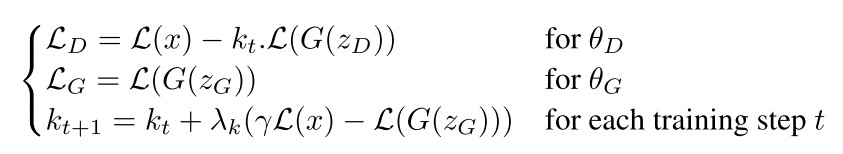

In [9]:
for epoch in range(epochs):
    for imgs in train_data:
        noise = tf.random.normal(shape=[batch_size, z_dim])
        margin =  max(1, batch_size / 64.0)

        with tf.GradientTape() as g:
            fake_images = G(noise)
            recon_fake = D(fake_images)
            recon_real = D(imgs)
            D_loss_real = MSE_loss(recon_real, imgs) - k * MSE_loss(recon_fake, tf.squeeze(fake_images))
            D_loss_fake = MSE_loss(recon_fake, tf.squeeze(fake_images))
            D_loss = D_loss_real - k * D_loss_fake

        gradients_D = g.gradient(D_loss,  D.trainable_variables)
        optimizer_D.apply_gradients(zip(gradients_D,  D.trainable_variables))

        noise = tf.random.normal(shape=[batch_size, z_dim])

        with tf.GradientTape() as g:
            fake_images = G(noise)
            recon_fake = D(fake_images)
            G_loss = MSE_loss(recon_fake, tf.squeeze(fake_images))
        
        gradients_G = g.gradient(G_loss,  G.trainable_variables)
        optimizer_G.apply_gradients(zip(gradients_G,  G.trainable_variables))

        k =  k + lambda_k * (gamma* D_loss_real - G_loss)
        k = min(1,max(0,k))


        
    print(f"epoch: {epoch+1}/{epochs}, G_loss: {G_loss}, D_loss: {D_loss}")

epoch: 1/20, G_loss: 0.014330513775348663, D_loss: 0.08728780597448349
epoch: 2/20, G_loss: 0.008593042381107807, D_loss: 0.0443924181163311
epoch: 3/20, G_loss: 0.013905053026974201, D_loss: 0.03144777566194534
epoch: 4/20, G_loss: 0.00988710019737482, D_loss: 0.028347142040729523
epoch: 5/20, G_loss: 0.014045861549675465, D_loss: 0.02252556011080742
epoch: 6/20, G_loss: 0.011859451420605183, D_loss: 0.023197395727038383
epoch: 7/20, G_loss: 0.010528489015996456, D_loss: 0.01965351775288582
epoch: 8/20, G_loss: 0.013703949749469757, D_loss: 0.01626264862716198
epoch: 9/20, G_loss: 0.010363337583839893, D_loss: 0.01555562112480402
epoch: 10/20, G_loss: 0.026362039148807526, D_loss: 0.01830427721142769
epoch: 11/20, G_loss: 0.01689031347632408, D_loss: 0.016384314745664597
epoch: 12/20, G_loss: 0.011896621435880661, D_loss: 0.013765919953584671
epoch: 13/20, G_loss: 0.008632407523691654, D_loss: 0.01347942091524601
epoch: 14/20, G_loss: 0.008275935426354408, D_loss: 0.014347441494464874

## **Visualization**

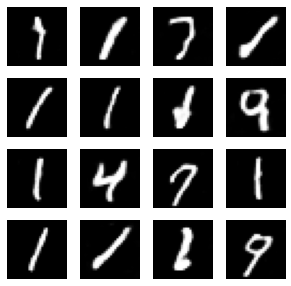

In [10]:
n = 4
z = tf.random.normal(shape=[n**2, z_dim])
gen_imgs = G(z, training=False)

fig = plt.figure(figsize=(5,5))

for i in range(gen_imgs.shape[0]):
    plt.subplot(n, n, i+1)
    plt.imshow(gen_imgs[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')

plt.show()